## Experiment showing KSD's decay for on-target samples (the variance problem)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import math
import torch.distributions as dists
from scem import loss, util, kernel, net, stein, cpdkernel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import dirname, join
import pickle
import ksdmom.sampler as samp
from collections import namedtuple

In [3]:
results_path = './results/varshift'
problem = 'Gaussian_ontarget'

In [4]:
dir_path = (join(results_path, problem))
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [5]:
torch.manual_seed(101)

In [6]:
font = {
    'family' : 'serif',
#     'weight' : 'bold',
    'size'   : 24
}
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', **font)
plt.rc('lines', linewidth=3, markersize=10)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


### Distributions 

In [7]:
class Normal:
    def __init__(self, m, s):
        self.m = m 
        self.s = s
    
    def den(self, X):
        m = self.m
        s = self.s 
        
        den = torch.exp(-torch.sum((X-m)**2, axis=1)/(2*s**2))
        den /= (2*math.pi*s**2)**(d/2)
        return den
    
    def log_den(self, X):
        m = self.m
        s = self.s
        ld = -torch.sum((X-m)**2, axis=1)/(2*s**2)
        ld -= d/2 * torch.log(torch.tensor(2*math.pi*s**2))
        return ld
    
    def score(self, X):
        m = self.m 
        s = self.s
        return -(X-m) / s**2
    
    def sample(self, n):
        m = self.m
        d = len(m)
        return m + self.s * torch.randn(n, d)
    
class MixNormal:
    def __init__(self, m1, m2, s1, s2, mweights=None):
        self.m1 = m1
        self.m2 = m2
        self.s1 = s1
        self.s2 = s2
        self.mweights = (mweights if mweights is not None else 
                         torch.ones(2)/2.)
    
    def score(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        mweights = self.mweights

        den1 = torch.exp(-torch.sum((X-m1)**2, axis=1)/(2*s1**2))
        den1 /= (2*math.pi*s1**2)**(d/2)
        den2 = torch.exp(-torch.sum((X-m2)**2, axis=1)/(2*s2**2))
        den2 /= (2*math.pi*s2**2)**(d/2)

        score1 = -(X - m1)/(s1**2) 
        score2 = -(X - m2)/(s2**2) 
        
        post_prob1 = mweights[0] * den1 / (mweights[0]*den1 + mweights[1]*den2)
        post_prob1 = post_prob1.unsqueeze(1)
        post_prob2 = 1. - post_prob1
        sc = post_prob1*score1 + post_prob2*score2
        return sc
    
    def den(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        w = self.mweights
        den1 = torch.exp(-torch.sum((X-m1)**2, axis=1)/(2*s1**2))
        den1 /= (2*math.pi*s1**2)**(d/2)
        den2 = torch.exp(-torch.sum((X-m2)**2, axis=1)/(2*s2**2))
        den2 /= (2*math.pi*s2**2)**(d/2)
        return w[0]*den1 + w[1]*den2
    
    def log_den(self, X):
        return torch.log(self.den(X))
    
    def sample(self, n):
        m = torch.distributions.Binomial(n, torch.tensor([self.mweights[0]]))        
        n1 = int(m.sample().item())
        n2 = n - n1 
        d = len(self.m1)
        X1 = self.s1*torch.randn(n1, d) + self.m1
        X2 = self.s2*torch.randn(n2, d) + self.m2
        X = torch.cat([X1, X2])
        for _ in range(30):
            idx = torch.randperm(n)
            X = X[idx]
        return X

In [8]:
rep = 1
n_ps = 100
d = 5
m = torch.zeros(d)
s = 1
target = Normal(m, s)

### Defining kernels

In [9]:
kimq  = kernel.KIMQ()
loc = None
klin = kernel.KLinear(scale=1, loc=loc, bias=1)
w = kernel.MultiquadraticWeight(p=-0.5, bias=1, loc=loc)
kw = kernel.KSTWeight(w_func=w)
ktilted_lin = kernel.KSTProduct(klin, kw)
ksum_imq = kernel.KSTSumKernel([ktilted_lin, kimq])

w_ = kernel.MultiquadraticWeight(p=(1.)/2, bias=1, loc=loc)
kw_ = kernel.KSTWeight(w_func=w_)
kx = kernel.KSTProduct(ksum_imq, kw_)

w_ = kernel.MultiquadraticWeight(p=(1.)/2, bias=1, loc=loc)
kw_ = kernel.KSTWeight(w_func=w_)
kx_zero = kernel.KSTProduct(ksum_imq, kw_)


kmat = kernel.KMatern(scale=1)
kmat_sum = kernel.KSTSumKernel([ktilted_lin, kimq])
kmat_sum = kernel.KSTProduct(kmat_sum, kw_)

kernels = {
    'IMQ': kimq, 
    # 'IMQ-sum-quad-theta': kx,
    'IMQ-sum-quad': kx_zero,
    'IMQ-sum': ksum_imq,
#     'Mat-sum': kmat_sum,
}


In [10]:
rerun = False
vstat = True

n_ps = 30
sample_sizes = torch.logspace(2, 4, n_ps)
data = np.empty([len(kernels), rep, n_ps])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}
sampler = target
for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}.npy'.format(key) if not vstat else
        '{}_vstat.npy'.format(key)
    )
    path = os.path.join(dir_path, filename)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp
    else:
        for j, n in enumerate(sample_sizes):
            for i in range(rep):
                X = sampler.sample(int(n.item()))
                data[l_i, i, j] = l.loss(X, vstat=vstat).detach().numpy()
        result = data[l_i]
        np.save(path, result)               

In [11]:
Format = namedtuple('Format', ['color', 'linestyle'])
label_format_tuples = {
    'IMQ': ("IMQ", Format('C1', '-')),
    'IMQ-sum': ('IMQ sum (lin.)', Format('C2', '--')),
#     'IMQ-sum-quad-theta': ('IMQ sum (quad.) $\\theta=0.1$', Format('C5', '-.')),
    'IMQ-sum-quad': ('IMQ sum (quad.)', Format('C6', ':')),
}


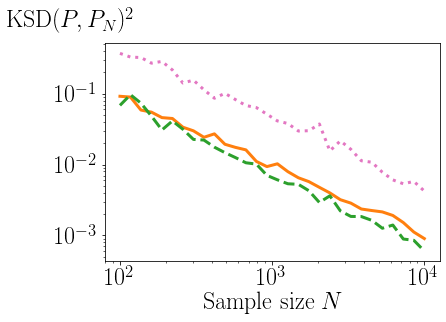

In [12]:
from matplotlib.ticker import LogLocator
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')


label = ax.set_xlabel('Sample size $N$', fontsize = 24)
label = ax.set_ylabel('$\\mathrm{KSD}(P, P_N)^2$', fontsize = 24)
label.set_rotation(0)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.1, 1.05)    

ax.set_yticks([1e+0, 1e+1, 1e+2])

ps = sample_sizes.detach().numpy()
for ki, key in enumerate(losses.keys()):
    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
    y = data[ki].mean(axis=0)
    ax.plot(ps, y, label=label, 
        color=fmt.color, linestyle=fmt.linestyle)

# ax.legend(bbox_to_anchor=(1.75,1.), ncol=4)
ax.set_yscale('log')
ax.set_xscale('log')

#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
 
plt.savefig('ksd_gauss_var_ontarget.pdf', bbox_inches='tight')